# Traditional Time-Series Forecasting

This notebook implements a traditional time-series prediction baseline for Smart Home Air Monitoring.

**Goal:** Use the previous 30 seconds of readings from R1–R4 to predict (R3, R4) 10 seconds into the future.

We frame forecasting as a supervised learning problem using sliding windows (lag features), then train and evaluate:
- Linear Regression (baseline)
- Ridge Regression (regularized baseline)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [2]:
def in_colab():
    return "COLAB_GPU" in os.environ or "google.colab" in sys.modules

if in_colab():
    # Running in Google Colab
    repo_path = "/content/MSAAI_530_FinalProject"
    data_path = "/content/MSAAI_530_FinalProject/data"

    # Set working directory to the repo root
    os.chdir(repo_path)

else:
    # Running locally in VS Code
    repo_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
    data_path = os.path.abspath(os.path.join(repo_path, "data"))

    # Add repo root to Python path
    if repo_path not in sys.path:
        sys.path.append(repo_path)

    # Set working directory to the repo root
    os.chdir(repo_path)

print("Using repo path:", repo_path)
print("Using data path:", data_path)
print("CWD:", os.getcwd())

Using repo path: /Users/nisunalade/Documents/Education/Graduate/MastersAI/MSAAI_530_FinalProject
Using data path: /Users/nisunalade/Documents/Education/Graduate/MastersAI/MSAAI_530_FinalProject/data
CWD: /Users/nisunalade/Documents/Education/Graduate/MastersAI/MSAAI_530_FinalProject


In [3]:
# Load and basic cleanup
dataset_csv = os.path.join(data_path, "Cleaned_HT_Sensor_Dataset.csv")

# Load CSVs
df = pd.read_csv(dataset_csv, delimiter=",").sort_values(["id","time"]).reset_index(drop=True)

SENSOR_COLS = ["R1","R2","R3","R4"]
TARGET_COLS = ["R3", "R4"]
cols_to_fill = sorted(set(SENSOR_COLS + TARGET_COLS))

# Time-series setup
WINDOW = 30   # past 30 seconds (lag window)
HORIZON = 10  # predict 10 seconds into the future

print("Setup complete.")

Setup complete.


In [4]:
# Fill missing sensor values within each recording using forward/back fill
df[cols_to_fill] = (
    df.groupby("id")[cols_to_fill]
      .apply(lambda g: g.ffill().bfill())
      .reset_index(level=0, drop=True)
)

# Confirm no missing values remain for modeled columns
print("Dataset shape:", df.shape)
print("Missing values per column:")
print(df[SENSOR_COLS].isna().sum())

Dataset shape: (12815, 12)
Missing values per column:
R1    0
R2    0
R3    0
R4    0
dtype: int64


<Axes: >

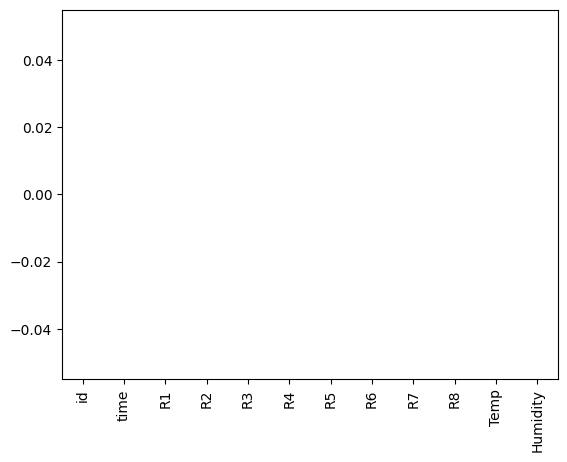

In [5]:
# Visualize missing data
df.isna().sum().plot.bar()

## 1. Convert time series to supervised learning (sliding windows)

For each recording id, we create many training examples:
- Input (X): the past window seconds of sensor readings (flattened)
- Target (y): the sensor value at horizon seconds into the future

This is the standard way to use traditional ML models for forecasting.


In [6]:
def make_windows(group: pd.DataFrame, feature_cols, target_col, window=30, horizon=10):
    """Create supervised learning samples from one recording (one id).

    X: [num_samples, window * num_features]
    y: [num_samples,]
    t: target timestamps (for plotting)
    """
    X_list, y_list, t_list = [], [], []
    Xdata = group[feature_cols].to_numpy()
    ydata = group[target_col].to_numpy()
    times = group["time"].to_numpy()

    n = len(group)
    max_start = n - window - horizon + 1

    for start in range(max_start):
        end = start + window
        target_idx = end + horizon - 1
        X_list.append(Xdata[start:end].reshape(-1))
        y_list.append(ydata[target_idx])
        t_list.append(times[target_idx])

    return np.array(X_list), np.array(y_list), np.array(t_list)

print("Window function ready.")

Window function ready.


## 2. Train/Test split (time-aware)

To avoid data leakage, we split within each recording in time order:
- First 70% of windows -> training
- Last 30% of windows -> testing

This mimics real forecasting (training on earlier behavior, testing on later behavior).


In [7]:
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []
meta_test = []  # (id, time) for plotting

for gid, g in df.groupby("id"):
    g = g.reset_index(drop=True)
    X, y, t = make_windows(g, SENSOR_COLS, TARGET_COLS, window=WINDOW, horizon=HORIZON)

    # Skip very short recordings
    if len(X) < 50:
        continue

    split = int(len(X) * 0.7)
    X_train_list.append(X[:split])
    y_train_list.append(y[:split])

    X_test_list.append(X[split:])
    y_test_list.append(y[split:])
    meta_test.extend([(gid, ti) for ti in t[split:]])

X_train = np.vstack(X_train_list)
y_train = np.vstack(y_train_list)
X_test = np.vstack(X_test_list)
y_test = np.vstack(y_test_list)

print("Train X:", X_train.shape, "Train y:", y_train.shape)
print("Test  X:", X_test.shape,  "Test  y:", y_test.shape)

Train X: (8943, 120) Train y: (8943, 2)
Test  X: (3833, 120) Test  y: (3833, 2)


## 3. Train traditional forecasting models

We train two lightweight regression baselines:
1. **Linear Regression**: simplest interpretable baseline
2. **Ridge Regression**: linear regression with L2 regularization (helps reduce overfitting)


In [8]:
def per_target_metrics(y_true, y_pred, target_names):
    rows = []
    for i, name in enumerate(target_names):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        rmse = mean_squared_error(y_true[:, i], y_pred[:, i]) ** 0.5
        r2 = r2_score(y_true[:, i], y_pred[:, i])

        rows.append({"Target": name, "MAE": mae, "RMSE": rmse, "R2": r2})

    # Add overall average row (so your summary code works)
    rows.append({
        "Target": "OVERALL_AVG",
        "MAE": np.mean([r["MAE"] for r in rows]),
        "RMSE": np.mean([r["RMSE"] for r in rows]),
        "R2": np.mean([r["R2"] for r in rows]),
    })

    return pd.DataFrame(rows)

models = {
    "LinearRegression": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
    "Ridge(alpha=1.0)": Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
}

preds = {}
all_metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds[name] = y_pred
    all_metrics[name] = per_target_metrics(y_test, y_pred, TARGET_COLS)

# Overall comparison table
summary = pd.DataFrame([
    {
        "Model": name,
        "MAE (avg)": all_metrics[name].loc[all_metrics[name]["Target"]=="OVERALL_AVG", "MAE"].values[0],
        "RMSE (avg)": all_metrics[name].loc[all_metrics[name]["Target"]=="OVERALL_AVG", "RMSE"].values[0],
        "R2 (avg)": all_metrics[name].loc[all_metrics[name]["Target"]=="OVERALL_AVG", "R2"].values[0],
    }
    for name in all_metrics
]).sort_values("RMSE (avg)")

summary

,Model,MAE (avg),RMSE (avg),R2 (avg)
0,LinearRegression,0.008123,0.021530,0.999108
1,Ridge(alpha=1.0),0.009101,0.022783,0.999001


## 4. Plot predicted vs actual (one recording)

We plot predictions on a single test recording to show how well the model tracks the sensor trend.


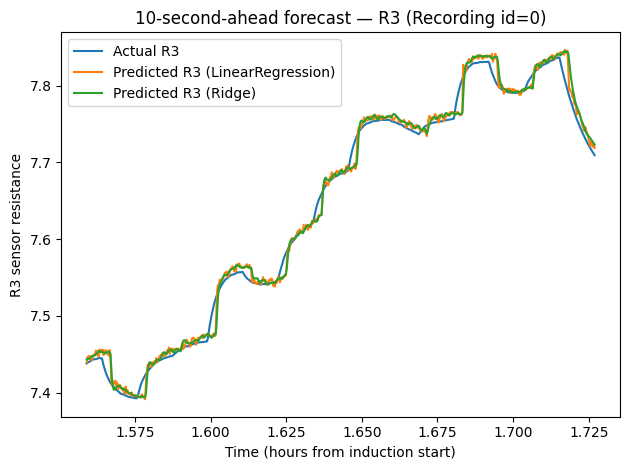

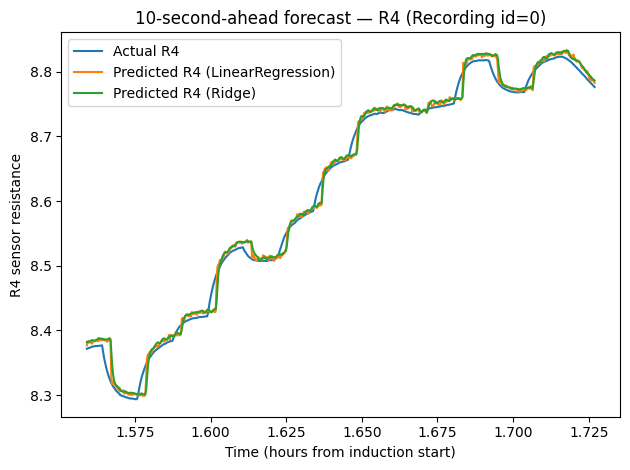

Saved plots: forecast_R3.png, forecast_R4.png


In [9]:
meta = pd.DataFrame(meta_test, columns=["id", "time"])
meta["actual_R3"] = y_test[:, 0]
meta["actual_R4"] = y_test[:, 1]

meta["pred_linreg_R3"] = preds["LinearRegression"][:, 0]
meta["pred_linreg_R4"] = preds["LinearRegression"][:, 1]

meta["pred_ridge_R3"] = preds["Ridge(alpha=1.0)"][:, 0]
meta["pred_ridge_R4"] = preds["Ridge(alpha=1.0)"][:, 1]

chosen_id = meta["id"].value_counts().idxmax()
sub = meta[meta["id"] == chosen_id].sort_values("time").head(600)

# Plot R3
plt.figure()
plt.plot(sub["time"], sub["actual_R3"], label="Actual R3")
plt.plot(sub["time"], sub["pred_linreg_R3"], label="Predicted R3 (LinearRegression)")
plt.plot(sub["time"], sub["pred_ridge_R3"], label="Predicted R3 (Ridge)")
plt.xlabel("Time (hours from induction start)")
plt.ylabel("R3 sensor resistance")
plt.title(f"{HORIZON}-second-ahead forecast — R3 (Recording id={chosen_id})")
plt.legend()
plt.tight_layout()
plt.savefig("forecast_R3.png", dpi=200)
plt.show()

# Plot R4
plt.figure()
plt.plot(sub["time"], sub["actual_R4"], label="Actual R4")
plt.plot(sub["time"], sub["pred_linreg_R4"], label="Predicted R4 (LinearRegression)")
plt.plot(sub["time"], sub["pred_ridge_R4"], label="Predicted R4 (Ridge)")
plt.xlabel("Time (hours from induction start)")
plt.ylabel("R4 sensor resistance")
plt.title(f"{HORIZON}-second-ahead forecast — R4 (Recording id={chosen_id})")
plt.legend()
plt.tight_layout()
plt.savefig("forecast_R4.png", dpi=200)
plt.show()

print("Saved plots: forecast_R3.png, forecast_R4.png")

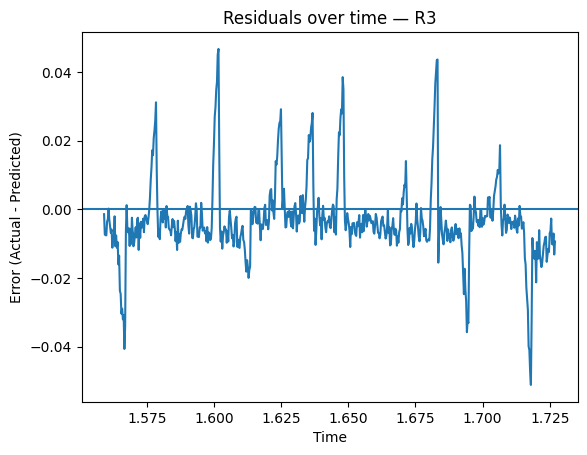

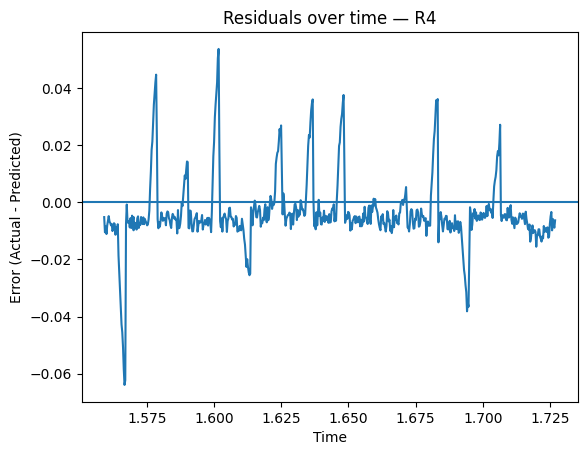

In [10]:
# Residual plots
residuals_R3 = sub["actual_R3"] - sub["pred_linreg_R3"]
residuals_R4 = sub["actual_R4"] - sub["pred_linreg_R4"]

plt.figure()
plt.plot(sub["time"], residuals_R3)
plt.axhline(0)
plt.title("Residuals over time — R3")
plt.xlabel("Time")
plt.ylabel("Error (Actual - Predicted)")
plt.show()

plt.figure()
plt.plot(sub["time"], residuals_R4)
plt.axhline(0)
plt.title("Residuals over time — R4")
plt.xlabel("Time")
plt.ylabel("Error (Actual - Predicted)")
plt.show()

## 5. Real time feasibility (IoT deployment note)

Because linear models are computationally lightweight, this approach is realistic for edge/gateway deployment:
- The device only keeps the most recent window seconds of readings in memory.
- Each prediction is a fast matrix operation (milliseconds on typical hardware).
- Results can be sent to the cloud/mobile app for visualization and alerting.
